In [1]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

In [2]:
from ultralytics import YOLOv10

In [3]:
!yolo task=detect mode=predict model=/kaggle/input/ckpckp/yolov10_detect_big.pt conf=0.25 source=/kaggle/input/vietnamese-license-plate-ocr/lpOCR/yolo save_crop=true

/opt/conda/lib/python3.10/site-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")
Ultralytics YO

In [4]:
!pip install -q transformers 

In [5]:
!pip install -q evaluate jiwer

In [6]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import os
import random
import matplotlib.pyplot as plt
from evaluate import load
from transformers import AdamW
from tqdm.notebook import tqdm
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, VisionEncoderDecoderConfig
import warnings
import wandb
import time

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = 'false'
wandb.login(key="4a5d274772a4974f7135c3fcdf92080c71668384")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/vietnamese-license-plate-ocr/labels.csv')
print(df.head())

        Name      Label Source
0  car_1.jpg  30F 11292   yolo
1  car_2.jpg  30F 78286   yolo
2  car_3.jpg  30F 90230   yolo
3  car_4.jpg  30E 49536   yolo
4  car_5.jpg  98A 29814   yolo


In [8]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Source'])
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Source'])

In [9]:
print(f"Training set size: {train_df.shape}")
print(f"Validation set size: {valid_df.shape}")
print(f"Test set size: {test_df.shape}")

Training set size: (1200, 3)
Validation set size: (150, 3)
Test set size: (150, 3)


In [10]:
def apply_augmentations(image):
    """Apply augmentations to the given image."""
    augmentation_pipeline = transforms.Compose([
        transforms.RandomRotation(degrees=(-5, 5)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.GaussianBlur(kernel_size=3),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    ])
    
    return augmentation_pipeline(image)

In [11]:
class LPDataset(Dataset):
    def __init__(self, data_frame, processor, max_target_length=10, augment=False):
        self.df = data_frame
        self.processor = processor
        self.max_target_length = max_target_length
        self.augmentation = augment
            
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        img_file = self.df.iloc[idx, 0]
        text = self.df.iloc[idx, 1]
        source = self.df.iloc[idx, 2]
        
        if source == "yolo":
            img_dir = "/kaggle/working/runs/detect/predict/crops/License_Plate"
        elif source == "cropped":
            img_dir = "/kaggle/input/vietnamese-license-plate-ocr/lpOCR/cropped"
        img_path = os.path.join(img_dir, img_file)
        
        # prepare image (i.e. resize + normalize)
        image = Image.open(img_path).convert("RGB")
        if self.augmentation:
            image = apply_augmentations(image)
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [12]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = LPDataset(data_frame=train_df, processor=processor, augment=True)
valid_dataset = LPDataset(data_frame=valid_df, processor=processor)
test_dataset = LPDataset(data_frame=test_df, processor=processor)

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [13]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))
print("Number of testing examples:", len(test_dataset))

Number of training examples: 1200
Number of validation examples: 150
Number of testing examples: 150


In [14]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([10])


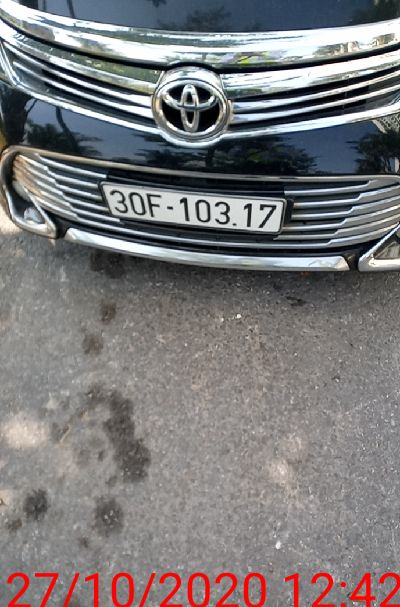

In [15]:
source = train_df.iloc[0,2]
if source == "yolo":
    data_dir = "/kaggle/input/vietnamese-license-plate-ocr/lpOCR/yolo"
elif source == "cropped":
    data_dir = "/kaggle/input/vietnamese-license-plate-ocr/lpOCR/cropped"
image = Image.open(os.path.join(data_dir, train_df.iloc[0,0])).convert("RGB")
image

In [16]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

30F 10317


In [17]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [18]:
from transformers import VisionEncoderDecoderModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
model.to(device)

config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [19]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 10
model.config.length_penalty = 0
model.config.early_stopping = True
model.config.num_beams = 2

In [20]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps", 
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True, 
    output_dir="/kaggle/working/LP-OCR-model",
    logging_steps=2,
    save_steps=50,
    eval_steps=50,
    num_train_epochs=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

In [21]:
cer_metric = load("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [36]:
model.save_pretrained("LP-OCR-model/best")

In [22]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator,
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: namnguyen2103. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Cer
50,0.165400,0.174251,0.030817
100,0.106200,0.191931,0.032357
150,0.205300,0.186850,0.019260
200,0.054200,0.165316,0.015408
250,0.045300,0.137698,0.013097
300,0.021100,0.106609,0.012327
350,0.013800,0.121155,0.013867


There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].


TrainOutput(global_step=380, training_loss=0.27161212457576767, metrics={'train_runtime': 1414.1751, 'train_samples_per_second': 8.486, 'train_steps_per_second': 0.269, 'total_flos': 8.979422291951616e+18, 'train_loss': 0.27161212457576767, 'epoch': 10.0})

In [23]:
# optimizer = AdamW(model.parameters(), lr=5e-5)
# num_epochs = 150
# best_valid_loss = float('inf')
# wandb.login(key="4a5d274772a4974f7135c3fcdf92080c71668384")
# wandb.init(project='LP-OCR',
#                    resume='allow',
#                    config={'num_epochs': num_epochs})
# wandb.watch(model)

In [24]:
# for epoch in range(num_epochs):
#     # ------------------- TRAIN -------------------
#     start = time.time()
#     model.train()
#     train_loss = 0.0

#     for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
#         # get the inputs and move to device
#         for k, v in batch.items():
#             batch[k] = v.to(device)

#         # forward + backward + optimize
#         outputs = model(**batch)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         train_loss += loss.item()

#     end = time.time()
#     train_loss /= len(train_dataloader)
    
#     # ------------------- VALID -------------------
#     model.eval()
#     valid_loss = 0.0
#     with torch.no_grad():
#         for batch in tqdm(valid_dataloader):
#             # run batch generation
#             outputs = model.generate(batch["pixel_values"].to(device))
#             # compute metrics
#             cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
#             valid_loss += cer

#     valid_loss /= len(valid_dataloader)
    
#     # ------------------- LOG -------------------
#     wandb.log({
#         'train_loss': train_loss,
#         'valid_loss': valid_loss,
#         'learning_rate': optimizer.param_groups[0]['lr']
#     })
    
#     # ------------------- VERBOSE -------------------
#     print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Validation CER: {valid_loss:.4f} | Time: {end-start:.2f}s')

#     # ------------------- CHECKPOINT -------------------
#     model.save_pretrained("LP-OCR-model/latest")
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         model.save_pretrained("LP-OCR-model/best")
#         print("New best checkpoint saved!")
        
# wandb.finish()

In [25]:
# loading model and config from pretrained folder
# encoder_decoder_config = VisionEncoderDecoderConfig.from_pretrained("/kaggle/input/captcha-ckp/LP-OCR-model/best")
# OCR_model = VisionEncoderDecoderModel.from_pretrained("/kaggle/input/captcha-ckp/LP-OCR-model/best", config=encoder_decoder_config).to(device)
# encoder_decoder_config = VisionEncoderDecoderConfig.from_pretrained("/kaggle/working/LP-OCR-model/best")
# LP_OCR_model = VisionEncoderDecoderModel.from_pretrained("/kaggle/working/LP-OCR-model/best", config=encoder_decoder_config).to(device)
LP_OCR_model = model

In [26]:
generated_text = []
with torch.no_grad():
    for batch in tqdm(DataLoader(train_dataset, batch_size=16)):
        # run batch generation
        outputs = LP_OCR_model.generate(batch["pixel_values"].to(device))
        generated_text_batch = processor.batch_decode(outputs, skip_special_tokens=True)
        generated_text.extend(generated_text_batch) 


  0%|          | 0/75 [00:00<?, ?it/s]

In [27]:
ground_truths = train_df.iloc[:, 1].tolist()

correct = 0
for generated, ground_truth in zip(generated_text, ground_truths):
    if generated == ground_truth:
        correct += 1

accuracy = correct / len(ground_truths) * 100
print(f"Train accuracy: {accuracy:.2f}%")

Train accuracy: 97.33%


In [28]:
generated_text = []
with torch.no_grad():
    for batch in tqdm(DataLoader(test_dataset, batch_size=16)):
        # run batch generation
        outputs = LP_OCR_model.generate(batch["pixel_values"].to(device))
        generated_text_batch = processor.batch_decode(outputs, skip_special_tokens=True)
        generated_text.extend(generated_text_batch) 


  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
ground_truths = test_df.iloc[:, 1].tolist()

correct = 0
for generated, ground_truth in zip(generated_text, ground_truths):
    if generated == ground_truth:
        correct += 1

accuracy = correct / len(ground_truths) * 100
print(f"Test accuracy: {accuracy:.2f}%")

Test accuracy: 93.33%


In [30]:
YOLO_model = YOLOv10("/kaggle/input/ckpckp/yolov10_detect_big.pt")

In [31]:
def get_label_from_name(df, image_file_name):
    # Check if the image file exists in the DataFrame
    label_row = df[df['Name'] == image_file_name]
    
    if not label_row.empty:
        return label_row['Label'].values[0]
    else:
        return None

def random_infer():
    # Get a random image path from the test folder
    data_dir = "/kaggle/input/vietnamese-license-plate-ocr/lpOCR/yolo"
    image_files = os.listdir(data_dir)
    random_image_file = random.choice(image_files)
    label = get_label_from_name(df, random_image_file)
    print("Label: " + label)
    
    image_path = os.path.join(data_dir, random_image_file)
    image = Image.open(image_path)
    plt.imshow(image)

    # Process the image
    yolo_results = YOLO_model(image) 
    if len(yolo_results) > 0:        
        bbox = yolo_results[0].boxes.xyxy[0]  
        xmin, ymin, xmax, ymax = map(int, bbox)
        cropped_image = image.crop((xmin, ymin, xmax, ymax))

        # Process the cropped image with OCR
        pixel_values = processor(cropped_image, return_tensors="pt").pixel_values.to(device)

        # Generate text from the image using OCR
        generated_ids = LP_OCR_model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        print(f"Generated text: {generated_text}")

        return generated_text
    else:
        print("No license plate detected")
        return None

Label: 59F1 38151

0: 416x640 1 License_Plate, 78.1ms
Speed: 12.9ms preprocess, 78.1ms inference, 23.2ms postprocess per image at shape (1, 3, 416, 640)
Generated text: 59F1 38151


'59F1 38151'

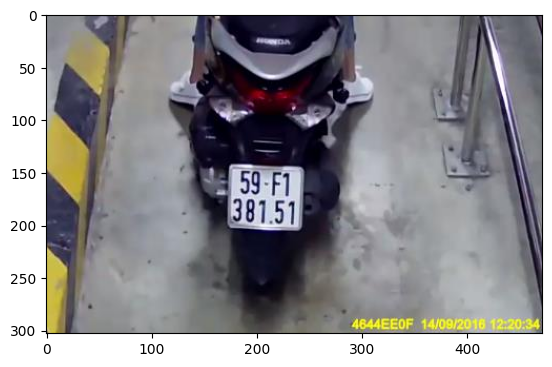

In [32]:
random_infer()

In [33]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))


In [37]:
download_file('/kaggle/working/LP-OCR-model/best', 'ckp')

/kaggle/working/ckp.zip